Since [scipy](https://scipy.org/) 0.19, scientific Python programmers have had access to [`scipy.LowLevelCallable`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.LowLevelCallable.html), a facility that allows you to use native compiled functions (be they written in C, Cython, or even [numba](https://ilovesymposia.com/2017/03/12/scipys-new-lowlevelcallable-is-a-game-changer/)) to speed things like numeric integration and image filtering up.

`LowLevelCallable` supports loading functions from a Cython module natively, but this only works if there is a Cython module to load the function from. If you're working in a Jupyter notebook, you might want to use the `%%cython` magic, in which case there *is* no module in the first place.

However, with some trickery, we can persuade `%%cython` magic code to hand over its functions to scipy.

Let's say we want to compute the Gaussian integral numerically.

$$f(a) = \int\limits_{-\infty}^{+\infty}\,e^{-ax^2}\,\mathrm{d}x = \sqrt{\frac{\pi}{a}}$$

This is of course a silly example, but it's easy to verify the results are correct seeing as we know the analytical solution.

A simple approach to integrating this as a pure Python function might look like this:

In [1]:
import numpy as np
from scipy.integrate import quad

def integrand(x, a):
    return np.exp(-a*x**2)

@np.vectorize
def gauss_py(a):
    y, abserr = quad(integrand, -np.inf, np.inf, (a,))
    return y

Here I'm creating a simple Python function representing the integrand, and integrating it up with scipy's [`quad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) function. This is wrapped in a vectorized function to make computing the result for different values of `a` easier.

In [2]:
%%time
a = np.linspace(0.1, 10, 10000)

py_result = gauss_py(a)

CPU times: user 3.73 s, sys: 88.4 ms, total: 3.82 s
Wall time: 3.71 s


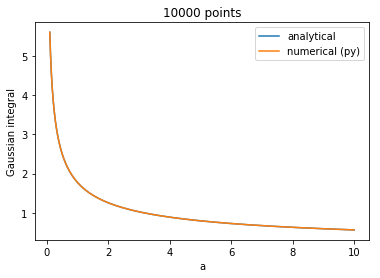

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(a, np.sqrt(np.pi/a), label='analytical')
plt.plot(a, py_result, label='numerical (py)')
plt.title(f'{len(a)} points')
plt.xlabel('a')
plt.ylabel('Gaussian integral')
plt.legend()

This works very nicely, but several seconds to compute a mere 10<sup>4</sup> values of this simple integral doesn't bode well for more complex computations (suffice it to say I had a reason to learn how to use Cython for this purpose).

There are three ways to construct a ``scipy.LowLevelCallable``:

 * from a function in a cython module
 * from a ctypes or cffi function pointer
 * from a [PyCapsule](https://docs.python.org/3/c-api/capsule.html) – a Python C API facility used to safely pass pointers through Python code
 
The first option is out in a notebook. The second *might* be possible, but using a PyCapsule sounds like a safe bet. So let's do that! As Cython provides us with easy access to the CPython API, we can easily get access to the essential functions `PyCapsule_New` and `PyCapsule_GetPointer`.

The main objective is to create an integrand function with the C signature

    double func(double x, void *user_data)
to pass to `quad()`, with the ``user_data`` pointer containing the parameter `a`. With `quad()`, there's a simpler way to pass in arguments, but for sake of demonstration I'll use the method that works with `dblquad()` and `nquad()` as well.

In [4]:
%load_ext cython

In [5]:
%%cython

from cpython.pycapsule cimport (PyCapsule_New,
                                PyCapsule_GetPointer)
from cpython.mem cimport PyMem_Malloc,  PyMem_Free
from libc.math cimport exp
import scipy

cdef double c_integrand(double x, void* user_data):
    """The integrand, written in Cython"""
    # Extract a.
    # Cython uses array access syntax for pointer dereferencing!
    cdef double a = (<double*>user_data)[0]
    return exp(-a*x**2)

#
# Now comes some classic C-style housekeeping
#

cdef object pack_a(double a):
    """Wrap 'a' in a PyCapsule for transport."""
    # Allocate memory where 'a' will be saved for the time being
    cdef double* a_ptr = <double*> PyMem_Malloc(sizeof(double))
    a_ptr[0] = a
    return PyCapsule_New(<void*>a_ptr, NULL, free_a)

cdef void free_a(capsule):
    """Free the memory our value is using up."""
    PyMem_Free(PyCapsule_GetPointer(capsule, NULL))

def get_low_level_callable(double a):
    # scipy.LowLevelCallable expects the function signature to
    # appear as the "name" of the capsule
    func_capsule = PyCapsule_New(<void*>c_integrand,
                                 "double (double, void *)",
                                 NULL)
    data_capsule = pack_a(a)
    
    return scipy.LowLevelCallable(func_capsule, data_capsule)

At this point, we should be able to use our `LowLevelCallable` from Python code!

In [6]:
@np.vectorize
def gauss_c(a):
    c_integrand = get_low_level_callable(a)
    y, abserr = quad(c_integrand, -np.inf, np.inf)
    return y

In [7]:
%%time
a = np.linspace(0.1, 10, 10000)

c_result = gauss_c(a)

CPU times: user 154 ms, sys: 4.69 ms, total: 159 ms
Wall time: 159 ms


As you can see, even for such a simple function, using Cython like this results in a speed-up by more than an order of magnitude, and the results are, of course, the same:

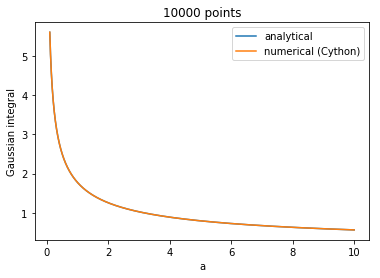

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(a, np.sqrt(np.pi/a), label='analytical')
plt.plot(a, c_result, label='numerical (Cython)')
plt.title(f'{len(a)} points')
plt.xlabel('a')
plt.ylabel('Gaussian integral')
plt.legend()

Download this notebook [from GitHub](https://github.com/tjol/toy-notebooks/blob/master/LowLevelCallable%20Notebook.ipynb).

<small class="license">
<a rel="license" class="license-logo" href="http://creativecommons.org/publicdomain/zero/1.0/"><img alt="CC0" style="border-width:0" src="http://i.creativecommons.org/p/zero/1.0/88x31.png"></a> To the extent possible under law,
  <span resource="[_:publisher]" rel="dct:publisher">
    <span property="dct:title">Thomas Jollans</span></span>
  has waived all copyright and related or neighboring rights to
  <b property="dct:title">the example code in this article</b>.
This work is published from the
<span property="vcard:Country" datatype="dct:ISO3166"
      content="NL" about="[_:publisher]">
  Netherlands</span>..
</small>
